In [1]:
%matplotlib inline
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
def loadCSV(file):
    """
    Load a CSV file
    
    Parameters
    ----------
    file: string (containing .csv extension)
    
    Returns
    -------
    data: numpy array, where entries are strings
    """
    with open(file,'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        data = []
        for row in csvreader:
            data.append(row)
    return np.array(data)

def cleanData(data, dataStart = 3):
    """
    Create, from the raw data imported from a csv file, a useable list of dictionaries of questions & answers
    
    Parameters
    ----------
    data:                 numpy array, where entries are strings. Rows denote responses, and header row is questions.
    dataStart (optional): integer for starting row, default = 3, assuming first row(s) are headers
    
    Returns
    -------
    dataList: list of dictionaries, where index = response, key = question, keyval = answers. Allows for multiple answers to a question.
    """
    
    titles = [title.split('"')[-2] for title in data[2]]
    dataList = []
    
    for i in range(dataStart,len(data)):
        responseDict = {}
        for j in range(len(data[i])):
            responseDict.update({titles[j]: splitAnswer(data[i][j])})
        dataList.append(responseDict)
    return dataList

def splitAnswer(answer):
    """
    Some answers allow for mulitple responses, which are seperated by '- '
    
    Parameters
    ----------
    answer: string
    
    Returns
    -------
    parts: list of answers, where answers are strings
    """
    
    if answer == '':
        return [answer]
    parts = answer.split('- ')
    if parts[0] == '':
        parts = parts[1:]
        for i in range(len(parts)-1):
            if parts[i][-1] == ',':
                parts[i] = parts[i][:-1]
        return parts
    return parts

def probFunction(question,data):
    """
    create a "dictionary function", where keys = answers, keyvals = prob. of answer
    
    Parameters
    ----------
    question: string
    data:     list of dictionary responses, index = response, key = question, keyvals = answers
    
    Returns
    -------
    xPx: dictionary, where keys = answers, keyvals = prob of answer
    """
    
    xPx = {}
    norm = 0.0
    for response in data:
        skip = False
        try:
            answer = response[question]
        except KeyError:
            continue
        for part in answer:
            norm += 1.0
            if part in xPx:
                xPx[part] += 1.0
            else:
                xPx.update({part : 1.0})
    for x in xPx:
        xPx[x] = xPx[x]/norm
        
    return xPx

def jointProbFunction(question1,question2,data):
    """
    create a "dictionary function", where key tuples  = answer combinations, keyvals = prob. of answer combination
    
    Parameters
    ----------
    question1: string
    question2: string
    data:      list of dictionary responses, index = response, key = question, keyvals = answers
    
    Returns
    -------
    xyPxy: muli-dimensional dictionary, where key tuples = answer comb., keyvals = prob of answer comb.
    """
    
    xyPxy = {}
    norm = 0.0
    for response in data:
        try:
            answer1 = response[question1]
        except KeyError:
            continue
        try:
            answer2 = response[question2]
        except KeyError:
            continue
        for part1 in answer1:
            for part2 in answer2:
                norm += 1.0
                if (part1,part2) in xyPxy:
                    xyPxy[(part1,part2)] += 1.0
                else:
                    xyPxy.update({(part1,part2) : 1.0})
    for xy in xyPxy:
        xyPxy[xy] = xyPxy[xy]/norm
    
    return xyPxy

def entropy(question,data):
    xPx = probFunction(question,data)
    return sum(-xPx[x]*np.log(xPx[x]) for x in xPx)

def mutualInfo(question1,question2,data):
    """
    Find the mutual information between 2 questions.
    
    Parameters
    ----------
    question1: string
    question2: string
    data:      list of dictionaries, where index = response, key = question, keyval = answer
    
    Returns
    -------
    mutInfo: float
    """
    xPx = probFunction(question1,data)
    yPy = probFunction(question2,data)
    xyPxy = jointProbFunction(question1,question2,data)
    
    mutInfo = 0.0
    for x in xPx:
        for y in yPy:
            try:
                mutInfo += xyPxy[(x,y)]*(np.log(xyPxy[(x,y)]) - np.log(xPx[x]) - np.log(yPy[y]))
            except KeyError:
                pass
    
    return mutInfo

def mutualInfoShort(xPx,yPy,xyPxy):
    """
    Find the mutual information between 2 questions, where prob. functions have been pre-calculated
    
    Parameters
    ----------
    xPx: dictionary, where keys = answers, keyvals = prob of answer
    yPy: dictionary, where keys = answers, keyvals = prob of answer
    xyPxy: muli-dimensional dictionary, where key tuples = answer comb., keyvals = prob of answer comb.
    
    Returns
    -------
    mutInfo: float
    """
    mutInfo = 0.0
    for x in xPx:
        for y in yPy:
            try:
                mutInfo += xyPxy[(x,y)]*(np.log(xyPxy[(x,y)]) - np.log(xPx[x]) - np.log(yPy[y]))
            except KeyError:
                pass
    
    return mutInfo

In [3]:
surveyFiles = os.listdir('data')
rawData = [loadCSV('data/'+surveyFile) for surveyFile in surveyFiles]

In [4]:
surveyFiles

['PLIC  - Sept 20 (For Foothill - combined)_January 17, 2017_09.15.csv',
 '26)_January 17, 2017_09.20.csv',
 'PLIC  - Sept 13 (For UBC - combined)_January 17, 2017_09.18.csv',
 'PLIC  - Sept 20 (For Linn-Benton - combined)_January 17, 2017_09.14.csv',
 'PLIC  - August 26 (For Maine - combined)_January 17, 2017_09.17.csv',
 'PLIC  - Dec 3 (For Maine - combined) - Post_January 17, 2017_09.19.csv',
 'PLIC  - August 26 (For Rowan)_January 17, 2017_09.12.csv']

In [5]:
dataLists = [cleanData(survey) for survey in rawData]

In [6]:
allData = []
for dataList in dataLists:
    allData.extend(dataList)

In [7]:
useableData = []
for response in allData:
    try:
        if (response['finished'][0] == 'False') or (response['QID43_TEXT'][0] == '') or (response['QID38'][0] == 'Under 18 years') or (response['QID172040033'][0] == 'No'):
            pass
        else:
            useableData.append(response)
    except KeyError:
        pass
len(useableData)

503

In [8]:
titles = []
for i in range(len(dataLists)):
    firstResponse = dataLists[i][0]
    for title in firstResponse:
        if title in titles:
            pass
        else:
            titles.append(title)

In [9]:
allProbFuncs = {}
for title in titles:
    allProbFuncs.update({title : probFunction(title,useableData)})
allJointProbFuncs = {}
for title1 in titles:
    for title2 in titles:
        allJointProbFuncs.update({(title1,title2):jointProbFunction(title1,title2,useableData)})

In [10]:
mutInfoQuestions = {}
for title1 in titles:
    for title2 in titles:
        mutInfoQuestions.update({(title1,title2) : mutualInfoShort(allProbFuncs[title1],allProbFuncs[title2],allJointProbFuncs[(title1,title2)])})

In [11]:
g1Questions = ['QID14_1','QID15','QID64_x16','QID64_x18','QID64_x20','QID64_x17','QID64_x19','QID18','QID60_x8','QID60_x9','QID60_x5','QID60_x1','QID60_x7','QID60_x4','QID60_x11','QID60_x2','QID60_x18','QID60_x6','QID62']
g1Labels = ['how diff k','reason for "how diff k"','size of k diff','k diff comp. uncert','size of k uncert.','% diff','sig fig sim.','reasoning','other variables','outliers','bounces/trial','tirals/mass','k agreement','lab book qual.','analysis qual.','uncert. size','match pred.','# sigfigs','next steps']
g2Questions = ['QID20_1','QID21','QID61_x11','QID61_x5','QID61_x2','QID61_x8','QID61_x7','QID61_x9','QID61_x15','QID61_x4','QID61_x3','QID61_x1','QID61_x6','QID77_1','QID23','QID56_x4','QID56_x2','QID56_x5','QID56_x8','QID56_x3','QID56_x7','QID56_x6','QID56_x1','QID56_x9','QID24','QID79_1','QID80','QID81_x11','QID81_x5','QID81_x2','QID81_x8','QID81_x7','QID81_x9','QID81_x15','QID81_x4','QID81_x3','QID81_x1','QID81_x6','QID74','QID75','QID33','QID34','QID70_x9','QID70_x10','QID70_x6','QID70_x4','QID70_x3','QID70_x2','QID70_x1','QID70_x11','QID70_x5','QID70_x8','QID70_x7']
g2Labels = ['data/line diff.','reason for "data/line diff','residuals vs. uncert.','lab book qual.','residual trend','residual size','close to line','# outliers','graphs/analysis quality','meas. quality','uncert. size','how linear','error cross line','method quality','reasoning','prediction','graph qual.','size of k unc.','bounces/trial','trials/mass','other variables','lab book qual.','# masses','agree with G1','next steps','line fit','reasoning','resid. sizes','book quality','residual trend','residual size','close to line','# outliers','graph/analysis qual.','meas. qual','size of uncert.','linearity','err. cross line','next steps','reasoning','g1/g2 better?','reasoning','other variables','bounces/trial','trials/mass','lab book qual.','analysis qual.','uncert. size','# masses','agree with pred.','k agree','try diff','deal with unc.']
demQuestions = ['QID35','QID36','QID38','QID39','QID71']
demLabels = ['level','major','age','gender','race/ethnicity']
eLabel = ['entropy']

questions = []

questions.extend(g1Questions)
questions.extend(demQuestions)
questions.extend(g2Questions)

xlabels = []
xlabels.extend(g1Labels)
xlabels.extend(demLabels)
xlabels.extend(g2Labels)

ylabels = []
ylabels.extend(g1Labels)
ylabels.extend(demQuestions)
ylabels.extend(g2Labels)
ylabels.extend(eLabel)

zvals = [[mutInfoQuestions[(title1,title2)] for title1 in questions] for title2 in questions]

zvals.append([entropy(title1,useableData) for title1 in questions])

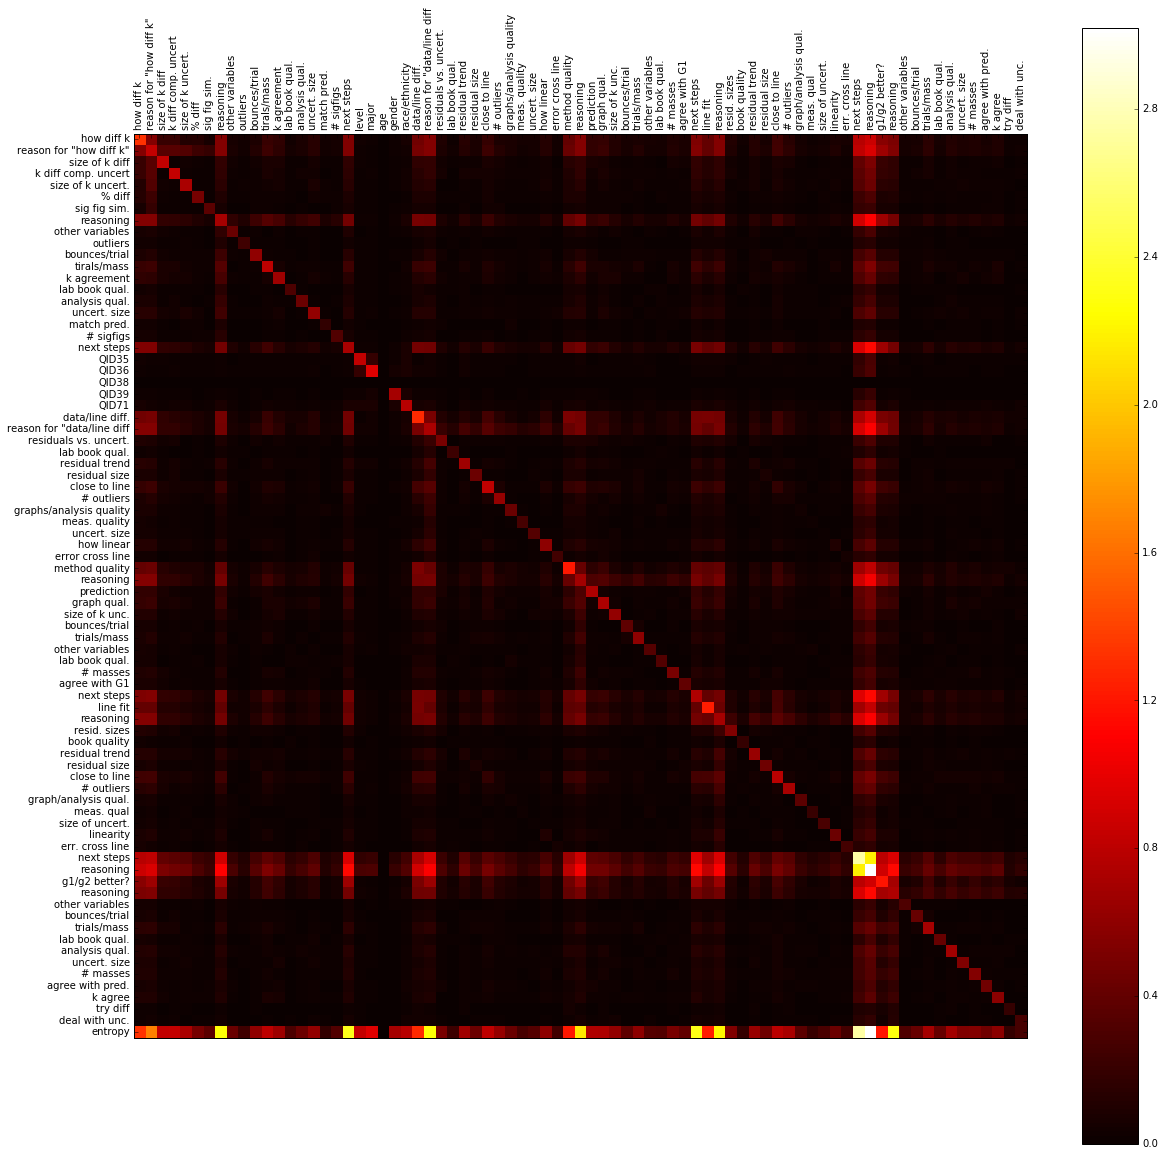

In [12]:
fig,axs = plt.subplots(figsize = (20,20))
img = plt.imshow(zvals,interpolation='nearest',cmap='hot')
plt.xticks([i for i in range(len(questions))],xlabels,rotation='vertical')
plt.yticks([i for i in range(len(questions)+1)],ylabels)
axs.xaxis.tick_top()
fig.colorbar(img)
plt.show()